In [1]:
include("../source/spin-1_XY_ED.jl")

S_minus_sq (generic function with 1 method)

#### 1) When $ J_2 = 0 $ 

In [2]:
N = 6
J1,J3,D,h = 1.0,0.1,0.1,1.0
boundary = "OBC"
use_sparse = false

@time begin
    nearest_bond_list = gen_bonds_1D(N,boundary)
    third_nbr_bond_list = gen_3rd_nbr_bonds_1D(N,boundary)
    basis_list = gen_basis_full_1D(N)
    neel_state = nematic_neel_1D(N,basis_list)
    ferro_state = nematic_ferro_1D(N,basis_list)
    target_state = [i % 3 == 1 ? 1 : i % 3 == 2 ? 0 : -1 for i in 1:N]
    prod_state::Vector{Float64} = [basis == target_state ? 1.0 : 0.0 for basis in basis_list]
    prod_state = prod_state/norm(prod_state)
    basis_new1 = similar(basis_list[1])
    basis_new2 = similar(basis_list[1])
    H_XY,H_size = Ham_XY_1D(J1,J3,D,h,N,basis_list,basis_new1,basis_new2,nearest_bond_list,
                            third_nbr_bond_list,use_sparse) 
end;

  0.222090 seconds (319.73 k allocations: 26.044 MiB, 95.47% compilation time)


In [83]:
@time energy,eigenvector = eigen(H_XY);

  0.086962 seconds (16 allocations: 12.426 MiB)


In [5]:
time_list = Vector{Float64}((LinRange(0,40,400)))
n_t = length(time_list)
t_step = time_list[2]-time_list[1]
evolved_neel_state_list::Vector{Vector{ComplexF64}} = Vector{Vector{ComplexF64}}(undef,n_t)
evolved_ferro_state_list::Vector{Vector{ComplexF64}} = Vector{Vector{ComplexF64}}(undef,n_t)
exp_H::Matrix{ComplexF64} = Matrix{ComplexF64}(undef,H_size,H_size)
evolved_state::Vector{ComplexF64} = Vector{ComplexF64}(undef,H_size)
eigenvector_inv::Matrix{Float64} = inv(eigenvector)

@time begin
    for i in 1:n_t
        t = time_list[i]  
        evolved_neel_state_list[i] = copy(state_evolution(exp_H,energy,eigenvector,eigenvector_inv,t,
                                                    neel_state,evolved_state))
        evolved_ferro_state_list[i] = copy(state_evolution(exp_H,energy,eigenvector,eigenvector_inv,t,
                                                    ferro_state,evolved_state))
    end
end;

 50.297650 seconds (9.76 k allocations: 19.046 GiB, 5.95% gc time, 0.02% compilation time)


In [41]:
r = 1
basis_new = similar(basis_list[1])

@time begin
    S_plus_sq_matrix,nematic_matrix_size = S_plus_sq(r,basis_list,basis_new)
    S_minus_sq_matrix,nematic_matrix_size = S_minus_sq(r,basis_list,basis_new)
end;

  0.002518 seconds (1.52 k allocations: 256.406 KiB)


##### $ \langle (S_r^+)^2 \rangle $

In [42]:
outvect::Vector{ComplexF64} = Vector{ComplexF64}(undef,nematic_matrix_size)
neel_plus_director_list::Vector{Float64} = Vector{Float64}(undef,n_t)
ferro_plus_director_list::Vector{Float64} = Vector{Float64}(undef,n_t)

@time begin
    for i in 1:n_t
        neel_t_evolved_state = evolved_neel_state_list[i]
        mul!(outvect,S_plus_sq_matrix,neel_t_evolved_state)
        neel_plus_director_list[i] = real(dot(neel_t_evolved_state,outvect))
        ferro_t_evolved_state = evolved_ferro_state_list[i]
        mul!(outvect,S_plus_sq_matrix,ferro_t_evolved_state)
        ferro_plus_director_list[i] = real(dot(ferro_t_evolved_state,outvect))
    end
end;

  0.002819 seconds (2.00 k allocations: 50.031 KiB)


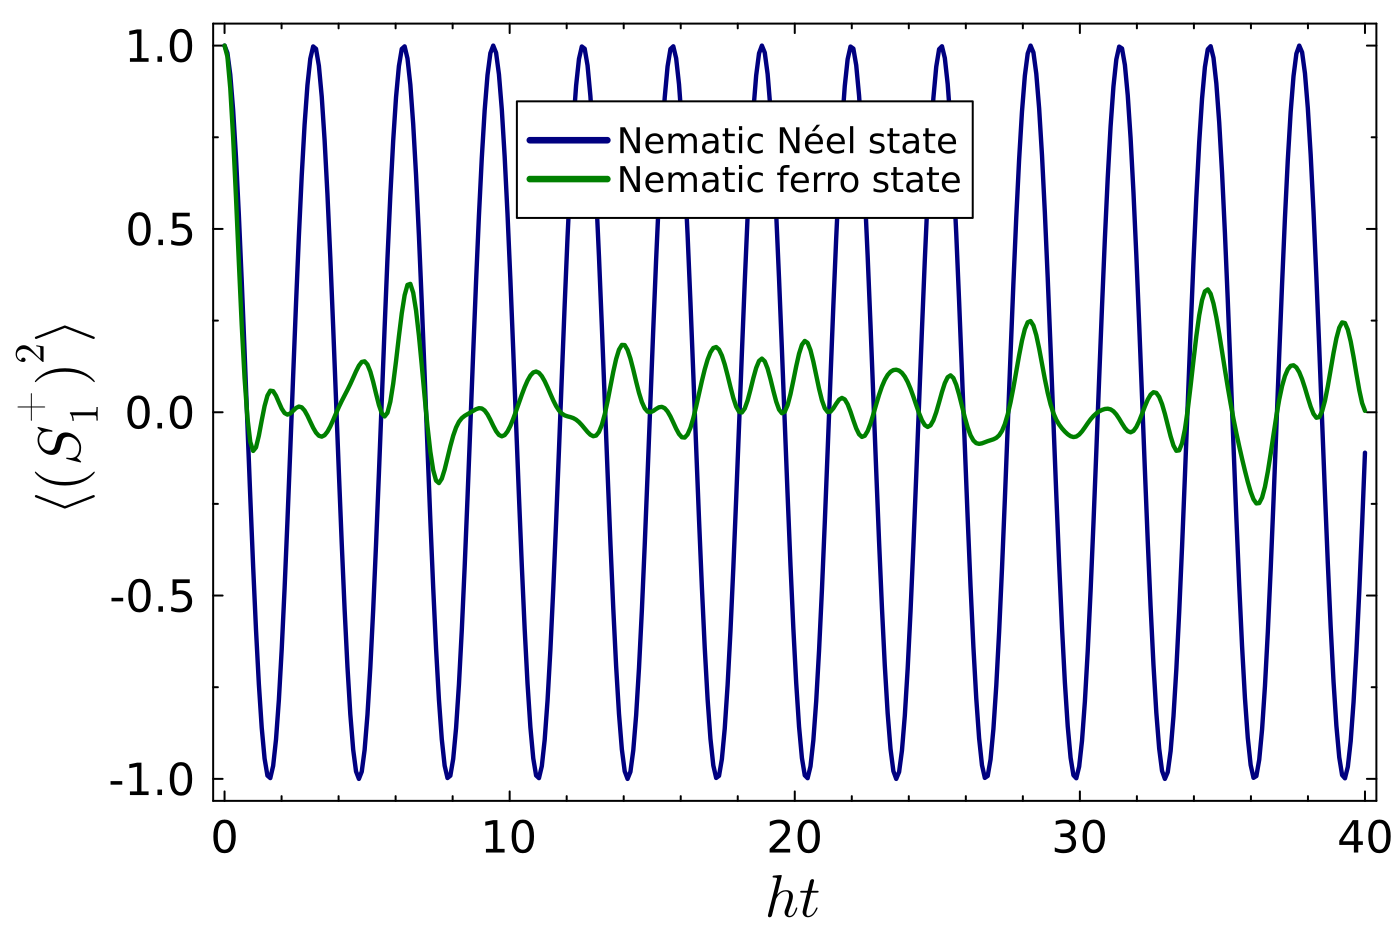

In [44]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

# Set the figure size
plot_size = (700,466.67)

# Define the plot
p = plot(h*time_list,neel_plus_director_list,lw=2.2,c=:navy,label="Nematic Néel state",size=plot_size,dpi=200)
plot!(h*time_list,ferro_plus_director_list,lw=2.2,c=:green,label="Nematic ferro state")

plot!(left_margin=4mm,right_margin=1mm,top_margin=1mm,bottom_margin=2mm)
plot!(framestyle=:box)
plot!(legend_position=(0.35,0.85),legendfontsize=12,legend_background_color=:white,legend_foreground_color=:black)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)

xlabel!("\$ht\$",guidefontsize=20)
ylabel!("\$\\langle(S_{$r}^{+})^2\\rangle\$",guidefontsize=20)
title_text = "\$ N = $N \\quad $boundary,\\ J_{1} = $(round(J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x_max = 40
y_min = -1
y_max = 1
xticks = (0:10:x_max,string.(0:10:x_max))
yticks = (y_min:0.5:y_max,string.(y_min:0.5:y_max))
xminor_ticks = 5 
yminor_ticks = 2
plot!(xlims=(-0.4,x_max+0.4))
plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
      xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=15,tick_direction=:in)

folder_name = "D:\\IACS_Project\\spin-1_XY\\Plots\\1D\\spin-1_XY_N=$(N)\\unperturbed\\$(boundary)"
if !isdir(folder_name)
    mkpath(folder_name)
end

file_path = joinpath(folder_name,"Nematic_directors_r=$(r)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)

##### $ \langle (S_r^-)^2 \rangle $

In [45]:
outvect::Vector{ComplexF64} = Vector{ComplexF64}(undef,nematic_matrix_size)
neel_minus_director_list::Vector{Float64} = Vector{Float64}(undef,n_t)
ferro_minus_director_list::Vector{Float64} = Vector{Float64}(undef,n_t)

@time begin
    for i in 1:n_t
        neel_t_evolved_state = evolved_neel_state_list[i]
        mul!(outvect,S_minus_sq_matrix,neel_t_evolved_state)
        neel_minus_director_list[i] = real(dot(neel_t_evolved_state,outvect))
        ferro_t_evolved_state = evolved_ferro_state_list[i]
        mul!(outvect,S_minus_sq_matrix,ferro_t_evolved_state)
        ferro_minus_director_list[i] = real(dot(ferro_t_evolved_state,outvect))
    end
end;

  0.004100 seconds (2.00 k allocations: 50.031 KiB)


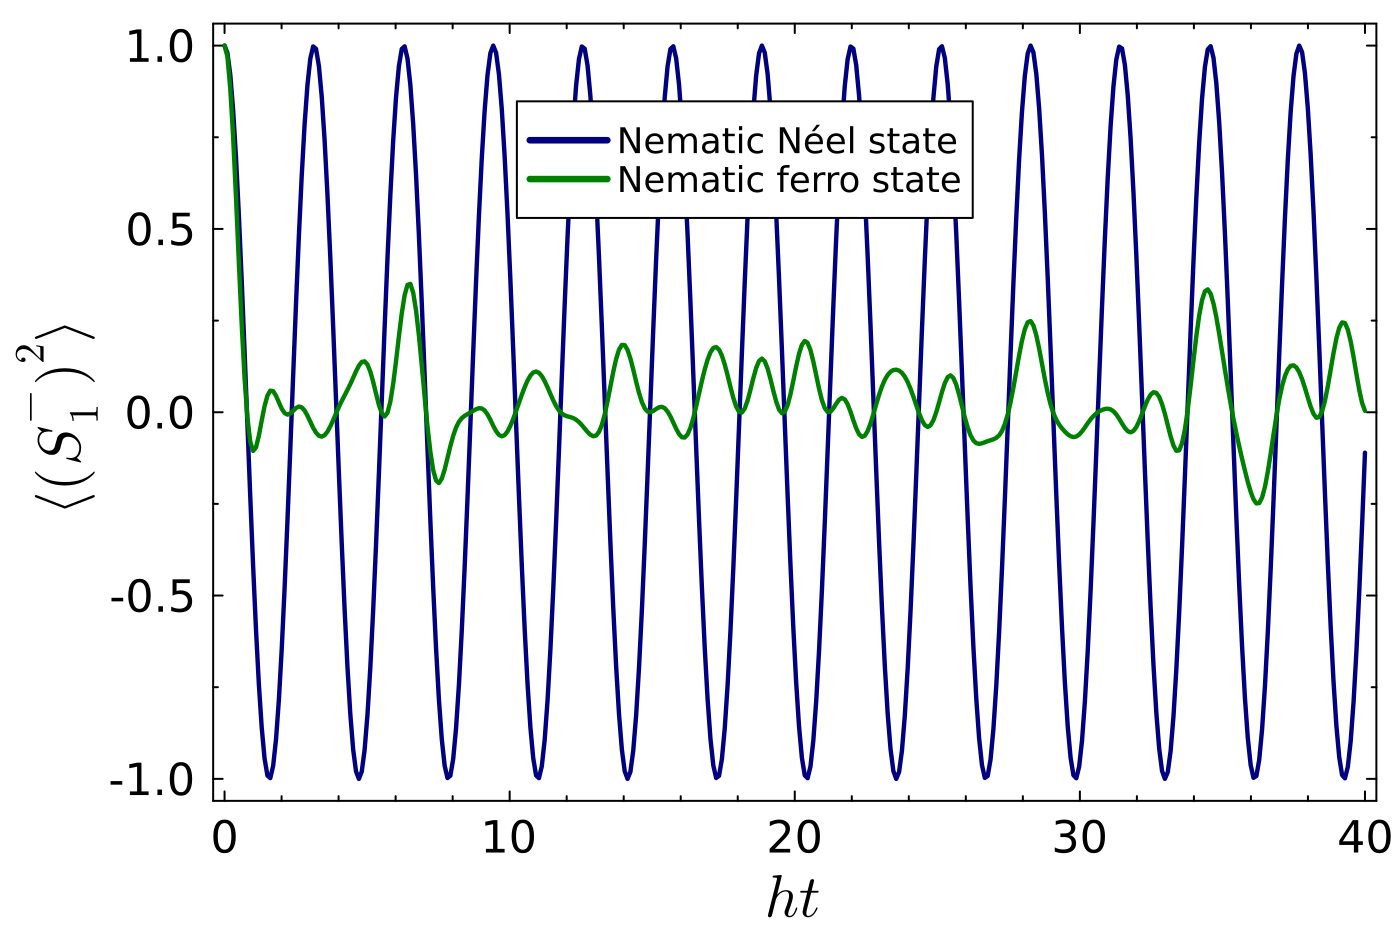

In [46]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

# Set the figure size
plot_size = (700,466.67)

# Define the plot
p = plot(h*time_list,neel_minus_director_list,lw=2.2,c=:navy,label="Nematic Néel state",size=plot_size,dpi=200)
plot!(h*time_list,ferro_minus_director_list,lw=2.2,c=:green,label="Nematic ferro state")

plot!(left_margin=4mm,right_margin=1mm,top_margin=1mm,bottom_margin=2mm)
plot!(framestyle=:box)
plot!(legend_position=(0.35,0.85),legendfontsize=12,legend_background_color=:white,legend_foreground_color=:black)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)

xlabel!("\$ht\$",guidefontsize=20)
ylabel!("\$\\langle(S_{$r}^{-})^2\\rangle\$",guidefontsize=20)
title_text = "\$ N = $N \\quad $boundary,\\ J_{1} = $(round(J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x_max = 40
y_min = -1
y_max = 1
xticks = (0:10:x_max,string.(0:10:x_max))
yticks = (y_min:0.5:y_max,string.(y_min:0.5:y_max))
xminor_ticks = 5 
yminor_ticks = 2
plot!(xlims=(-0.4,x_max+0.4))
plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
      xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=15,tick_direction=:in)

##### $ \langle O_r \rangle = \frac{1}{2} \langle [(S_r^+)^2+(S_r^-)^2] \rangle $

In [47]:
average_neel_nematic_director_list = (neel_plus_director_list+neel_minus_director_list)/2
average_ferro_nematic_director_list = (ferro_plus_director_list+ferro_minus_director_list)/2;

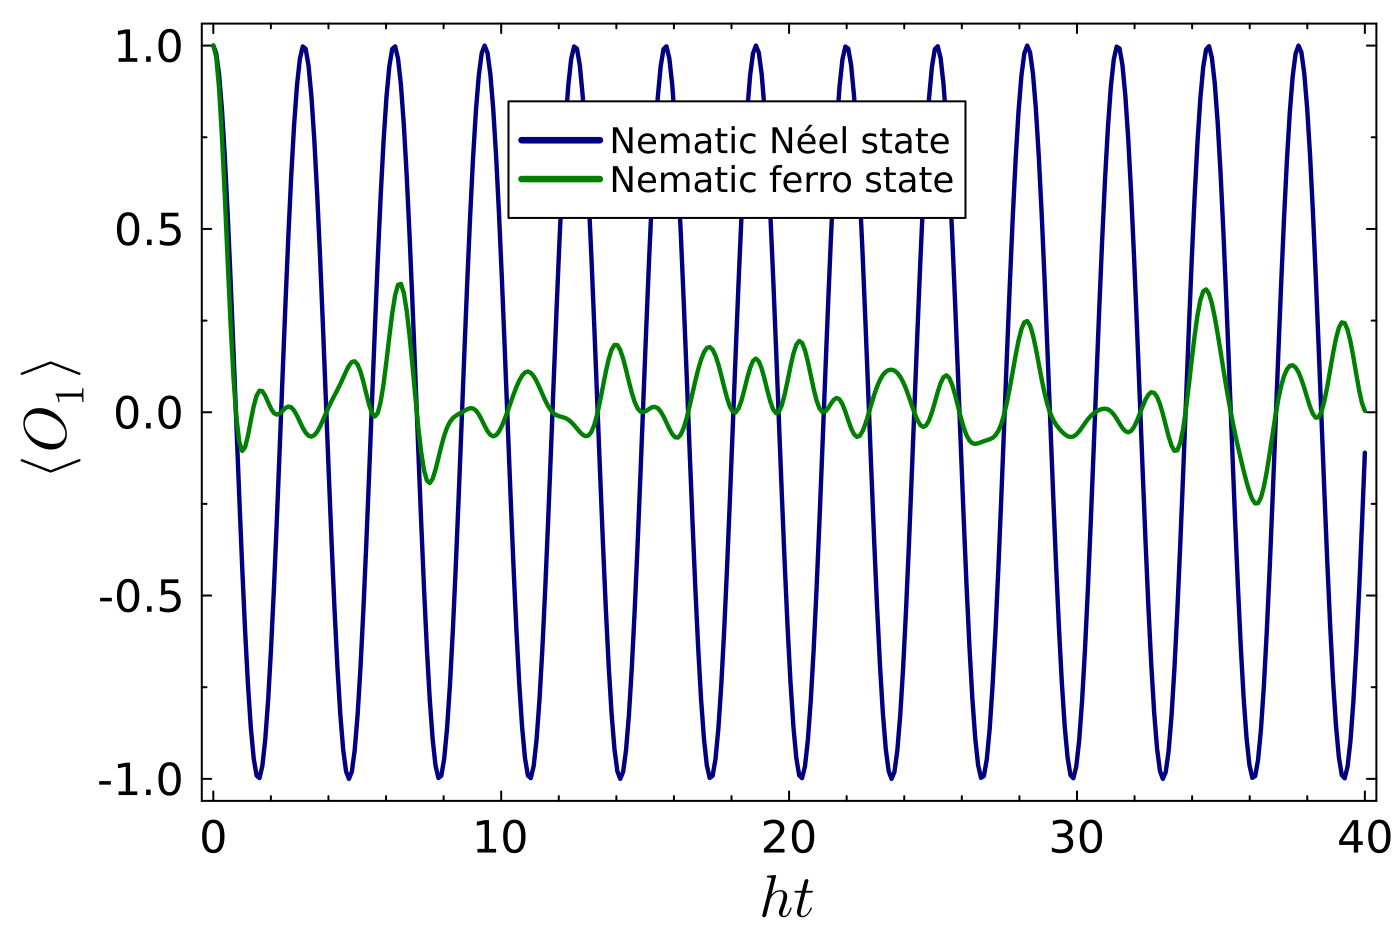

"D:\\IACS_Project\\spin-1_XY\\Plots\\1D\\spin-1_XY_N=6\\unperturbed\\OBC\\Nematic_directors_r=1_J1=1.0_J3=0.1_D=0.1_h=1.0.png"

In [48]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

# Set the figure size
plot_size = (700,466.67)

# Define the plot
p = plot(h*time_list,average_neel_nematic_director_list,lw=2.2,c=:navy,label="Nematic Néel state",size=plot_size,dpi=200)
plot!(h*time_list,average_ferro_nematic_director_list,lw=2.2,c=:green,label="Nematic ferro state")

plot!(left_margin=4mm,right_margin=1mm,top_margin=1mm,bottom_margin=2mm)
plot!(framestyle=:box)
plot!(legend_position=(0.35,0.85),legendfontsize=12,legend_background_color=:white,legend_foreground_color=:black)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)

xlabel!("\$ht\$",guidefontsize=20)
ylabel!("\$\\langle O_{$r}\\rangle\$",guidefontsize=20)
title_text = "\$ N = $N \\quad $boundary,\\ J_{1} = $(round(J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x_max = 40
y_min = -1
y_max = 1
xticks = (0:10:x_max,string.(0:10:x_max))
yticks = (y_min:0.5:y_max,string.(y_min:0.5:y_max))
xminor_ticks = 5 
yminor_ticks = 2
plot!(xlims=(-0.4,x_max+0.4))
plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
      xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=15,tick_direction=:in)

folder_name = "D:\\IACS_Project\\spin-1_XY\\Plots\\1D\\spin-1_XY_N=$(N)\\unperturbed\\$(boundary)"
if !isdir(folder_name)
    mkpath(folder_name)
end

file_path = joinpath(folder_name,"Nematic_directors_r=$(r)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)

#### When $ J_2 \neq 0 $

In [100]:
N = 6
J1,J3,D,h = 1.0,0.1,0.1,1.0
J2 = 0.03
boundary = "OBC"
use_sparse = false

@time begin
    nearest_bond_list = gen_bonds_1D(N,boundary)
    third_nbr_bond_list = gen_3rd_nbr_bonds_1D(N,boundary)
    sec_nbr_bond_list = gen_2nd_nbr_bonds_1D(N,boundary)
    basis_list = gen_basis_full_1D(N)
    ref_state = nematic_neel_1D(N,basis_list)
    basis_new1 = similar(basis_list[1])
    basis_new2 = similar(basis_list[1])
    H_XY,H_size = Ham_XY_1D(J1,J3,D,h,N,basis_list,basis_new1,basis_new2,nearest_bond_list,
                            third_nbr_bond_list,use_sparse)
    H_sec_nbr,H_size = Ham_2nd_nbr_1D(J2,N,basis_list,basis_new1,sec_nbr_bond_list,use_sparse)
    H_total = H_XY + H_sec_nbr
end;
println(H_size)

  0.014411 seconds (31.48 k allocations: 14.440 MiB)
729


In [101]:
@time energy,eigenvector = eigen(H_total);

  0.140795 seconds (16 allocations: 12.426 MiB)


In [102]:
time_list = Vector{Float64}((LinRange(0,160,800)))
n_t = length(time_list)
t_step = time_list[2]-time_list[1]
evolved_neel_state_list::Vector{Vector{ComplexF64}} = Vector{Vector{ComplexF64}}(undef,n_t)
evolved_ferro_state_list::Vector{Vector{ComplexF64}} = Vector{Vector{ComplexF64}}(undef,n_t)
exp_H::Matrix{ComplexF64} = Matrix{ComplexF64}(undef,H_size,H_size)
evolved_state::Vector{ComplexF64} = Vector{ComplexF64}(undef,H_size)
eigenvector_inv::Matrix{Float64} = inv(eigenvector)

@time begin
    for i in 1:n_t
        t = time_list[i]  
        evolved_neel_state_list[i] = copy(state_evolution(exp_H,energy,eigenvector,eigenvector_inv,t,
                                                    neel_state,evolved_state))
        evolved_ferro_state_list[i] = copy(state_evolution(exp_H,energy,eigenvector,eigenvector_inv,t,
                                                    ferro_state,evolved_state))
    end
end;

 67.845707 seconds (13.38 k allocations: 25.394 GiB, 5.77% gc time)


In [103]:
r = 1
basis_new = similar(basis_list[1])

@time begin
    S_plus_sq_matrix,nematic_matrix_size = S_plus_sq(r,basis_list,basis_new)
    S_minus_sq_matrix,nematic_matrix_size = S_minus_sq(r,basis_list,basis_new)
end;

  0.005937 seconds (1.52 k allocations: 256.406 KiB)


In [104]:
outvect::Vector{ComplexF64} = Vector{ComplexF64}(undef,nematic_matrix_size)
neel_plus_director_list::Vector{Float64} = Vector{Float64}(undef,n_t)
ferro_plus_director_list::Vector{Float64} = Vector{Float64}(undef,n_t)
neel_minus_director_list::Vector{Float64} = Vector{Float64}(undef,n_t)
ferro_minus_director_list::Vector{Float64} = Vector{Float64}(undef,n_t)

@time begin
    for i in 1:n_t
        neel_t_evolved_state = evolved_neel_state_list[i]
        mul!(outvect,S_plus_sq_matrix,neel_t_evolved_state)
        neel_plus_director_list[i] = real(dot(neel_t_evolved_state,outvect))
        
        mul!(outvect,S_minus_sq_matrix,neel_t_evolved_state)
        neel_minus_director_list[i] = real(dot(neel_t_evolved_state,outvect))
        
        ferro_t_evolved_state = evolved_ferro_state_list[i]
        mul!(outvect,S_plus_sq_matrix,ferro_t_evolved_state)
        ferro_plus_director_list[i] = real(dot(ferro_t_evolved_state,outvect))

        mul!(outvect,S_minus_sq_matrix,ferro_t_evolved_state)
        ferro_minus_director_list[i] = real(dot(ferro_t_evolved_state,outvect))
    end
end;

  0.011145 seconds (7.78 k allocations: 184.062 KiB)


In [105]:
average_neel_nematic_director_list = (neel_plus_director_list+neel_minus_director_list)/2
average_ferro_nematic_director_list = (ferro_plus_director_list+ferro_minus_director_list)/2;

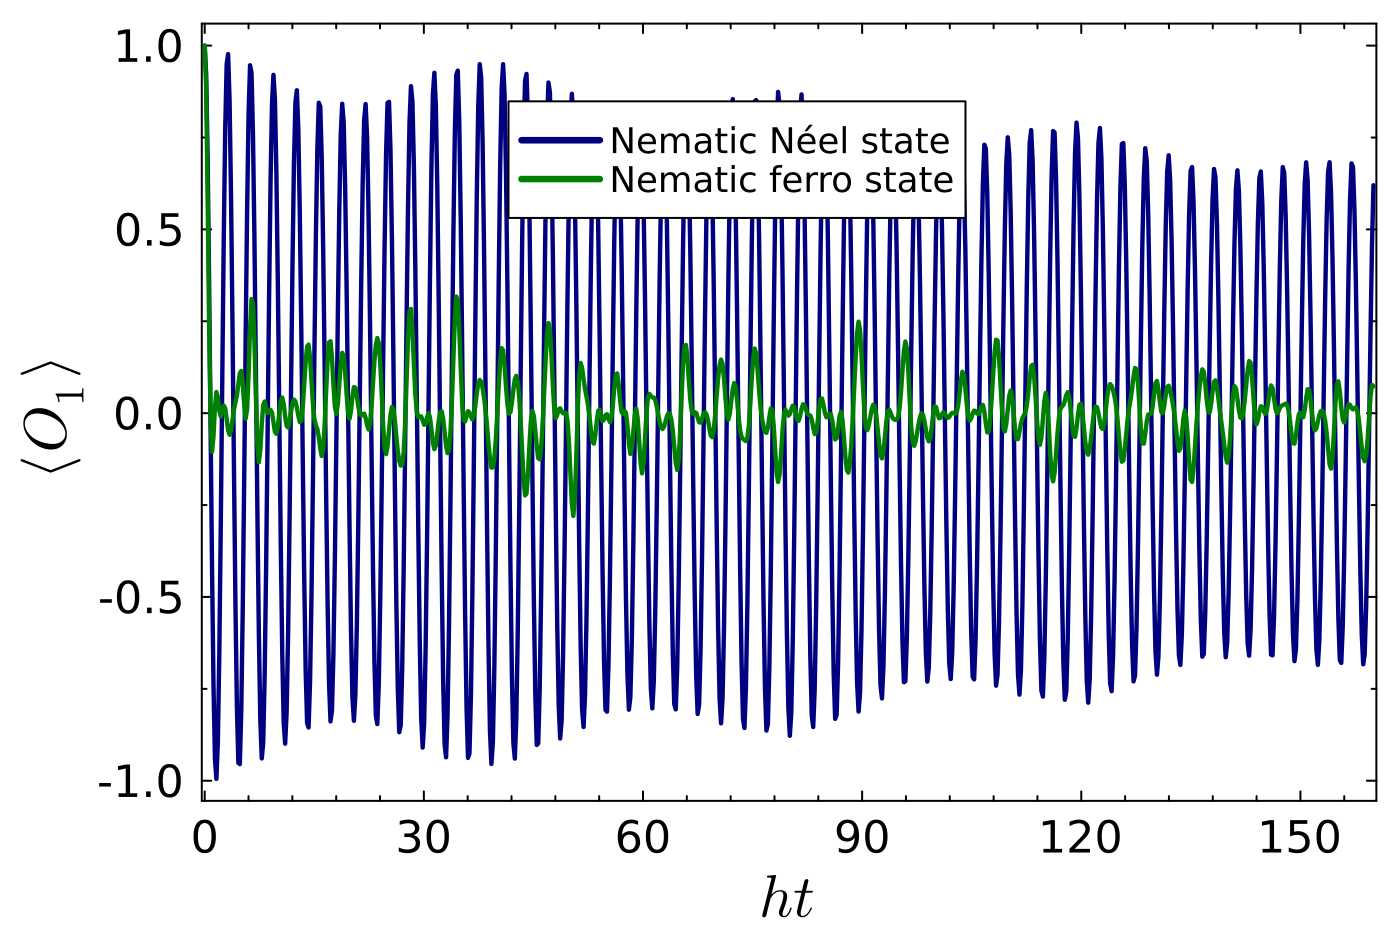

"D:\\IACS_Project\\spin-1_XY\\Plots\\1D\\spin-1_XY_N=6\\sec_nbr_perturbed\\OBC\\Nematic_directors_r=1_g=0.03_J3=0.1_D=0.1_h=1.0.png"

In [106]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

# Set the figure size
plot_size = (700,466.67)

# Define the plot
p = plot(h*time_list,average_neel_nematic_director_list,lw=2.2,c=:navy,label="Nematic Néel state",size=plot_size,dpi=200)
plot!(h*time_list,average_ferro_nematic_director_list,lw=2.2,c=:green,label="Nematic ferro state")

plot!(left_margin=4mm,right_margin=1mm,top_margin=1mm,bottom_margin=2mm)
plot!(framestyle=:box)
plot!(legend_position=(0.35,0.85),legendfontsize=12,legend_background_color=:white,legend_foreground_color=:black)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)

xlabel!("\$ht\$",guidefontsize=20)
ylabel!("\$\\langle O_{$r}\\rangle\$",guidefontsize=20)
title_text = "\$ N = $N \\quad $boundary,\\ J_{2}/J_{1} = $(round(J2/J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x_max = 160
y_min = -1
y_max = 1
xticks = (0:30:x_max,string.(0:30:x_max))
yticks = (y_min:0.5:y_max,string.(y_min:0.5:y_max))
xminor_ticks = 5 
yminor_ticks = 2
plot!(xlims=(-0.4,x_max+0.4))
plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
      xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=15,tick_direction=:in)

folder_name = "D:\\IACS_Project\\spin-1_XY\\Plots\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\$(boundary)"
if !isdir(folder_name)
    mkpath(folder_name)
end

file_path = joinpath(folder_name,"Nematic_directors_r=$(r)_g=$(round(J2/J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)